In [13]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import re
import datetime

In [4]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [170902, 170909, 170916, 170923, 170930, 171007, 171014, 171021, 171028, 171104, 171111, 171118, 171125, 171202,
            171209, 171216, 171223, 171230]
turnstiles = get_data(week_nums)

In [5]:
turnstiles.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,REGULAR,6303202,2133729
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,REGULAR,6303225,2133730
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,REGULAR,6303237,2133753
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,REGULAR,6303309,2133830
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,REGULAR,6303508,2133882


In [7]:
turnstiles.shape

(3566289, 11)

In [8]:
turnstiles.columns #I need to strip the stirngs in column in order to remove whitespaces

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [9]:
turnstiles.columns = [column.strip() for column in turnstiles.columns]
turnstiles.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [12]:
#turnstiles.DATE.value_counts().sort_index()

In [11]:
turnstiles.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,REGULAR,6303202,2133729
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,REGULAR,6303225,2133730
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,REGULAR,6303237,2133753
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,REGULAR,6303309,2133830
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,REGULAR,6303508,2133882


In [ ]:
#I will combine and convert the DATE and TIME columns 

In [14]:
turnstiles["DATE_TIME"] = pd.to_datetime(turnstiles.DATE + " " + turnstiles.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [15]:
turnstiles.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,REGULAR,6303202,2133729,2017-08-26 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,REGULAR,6303225,2133730,2017-08-26 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,REGULAR,6303237,2133753,2017-08-26 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,REGULAR,6303309,2133830,2017-08-26 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,REGULAR,6303508,2133882,2017-08-26 16:00:00


In [18]:
turnstiles.dtypes

C/A                  object
UNIT                 object
SCP                  object
STATION              object
LINENAME             object
DIVISION             object
DATE                 object
TIME                 object
DESC                 object
ENTRIES               int64
EXITS                 int64
DATE_TIME    datetime64[ns]
dtype: object

In [27]:
(turnstiles
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2017-08-26 00:00:00,1
2369669,R145,R032,00-00-04,TIMES SQ-42 ST,2017-12-23 11:00:00,1
2369658,R145,R032,00-00-04,TIMES SQ-42 ST,2017-12-21 15:00:00,1
2369659,R145,R032,00-00-04,TIMES SQ-42 ST,2017-12-21 19:00:00,1
2369660,R145,R032,00-00-04,TIMES SQ-42 ST,2017-12-21 23:00:00,1


In [20]:
turnstiles.DESC.value_counts()

REGULAR       3554497
RECOVR AUD      11792
Name: DESC, dtype: int64

In [23]:
#we need to remove recovery audtis as below:
turnstiles = turnstiles[turnstiles['DESC'] != 'RECOVR AUD']

In [24]:
turnstiles.DESC.unique()

array(['REGULAR'], dtype=object)

In [28]:
#I will drop the description column since we don't need it anymore
turnstiles = turnstiles.drop(["DESC"], axis=1, errors="ignore")

In [29]:
turnstiles.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,6303202,2133729,2017-08-26 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,6303225,2133730,2017-08-26 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,6303237,2133753,2017-08-26 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,6303309,2133830,2017-08-26 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,6303508,2133882,2017-08-26 16:00:00


In [32]:
#I will look for missing values
turnstiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3554497 entries, 0 to 197212
Data columns (total 11 columns):
C/A          object
UNIT         object
SCP          object
STATION      object
LINENAME     object
DIVISION     object
DATE         object
TIME         object
ENTRIES      int64
EXITS        int64
DATE_TIME    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 325.4+ MB


In [33]:
turnstiles.isna().sum() #no null values found

C/A          0
UNIT         0
SCP          0
STATION      0
LINENAME     0
DIVISION     0
DATE         0
TIME         0
ENTRIES      0
EXITS        0
DATE_TIME    0
dtype: int64

In [34]:
turnstiles.isna()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False


In [35]:
turnstiles.shape

(3554497, 11)

In [36]:
#we will check if we have duplicate rows and drop them
turnstiles.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [37]:
turnstiles.shape #no duplicated rows

(3554497, 11)

In [50]:
turnstiles_daily_entries = (turnstiles
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [51]:
turnstiles_daily_entries.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,08/26/2017,6303202
1,A002,R051,02-00-00,59 ST,08/27/2017,6303877
2,A002,R051,02-00-00,59 ST,08/28/2017,6304389
3,A002,R051,02-00-00,59 ST,08/29/2017,6305650
4,A002,R051,02-00-00,59 ST,08/30/2017,6306953


In [52]:
turnstiles_daily_exits = (turnstiles
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .EXITS.first())

In [53]:
turnstiles_daily_exits.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,08/26/2017,2133729
1,A002,R051,02-00-00,59 ST,08/27/2017,2133946
2,A002,R051,02-00-00,59 ST,08/28/2017,2134118
3,A002,R051,02-00-00,59 ST,08/29/2017,2134506
4,A002,R051,02-00-00,59 ST,08/30/2017,2134713


In [56]:
turnstiles_daily_entries[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily_entries
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

In [57]:
turnstiles_daily_exits[["PREV_DATE", "PREV_EXIT"]] = (turnstiles_daily_exits
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

In [58]:
turnstiles_daily_entries.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,08/26/2017,6303202,NaN,NaN
1,A002,R051,02-00-00,59 ST,08/27/2017,6303877,08/26/2017,6303202.0
2,A002,R051,02-00-00,59 ST,08/28/2017,6304389,08/27/2017,6303877.0
3,A002,R051,02-00-00,59 ST,08/29/2017,6305650,08/28/2017,6304389.0
4,A002,R051,02-00-00,59 ST,08/30/2017,6306953,08/29/2017,6305650.0


In [60]:
turnstiles_daily_exits.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXIT
0,A002,R051,02-00-00,59 ST,08/26/2017,2133729,NaN,NaN
1,A002,R051,02-00-00,59 ST,08/27/2017,2133946,08/26/2017,2133729.0
2,A002,R051,02-00-00,59 ST,08/28/2017,2134118,08/27/2017,2133946.0
3,A002,R051,02-00-00,59 ST,08/29/2017,2134506,08/28/2017,2134118.0
4,A002,R051,02-00-00,59 ST,08/30/2017,2134713,08/29/2017,2134506.0


In [61]:
turnstiles_daily_entries.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [62]:
turnstiles_daily_exits.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [63]:
turnstiles_daily_entries.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,08/27/2017,6303877,08/26/2017,6303202.0
2,A002,R051,02-00-00,59 ST,08/28/2017,6304389,08/27/2017,6303877.0
3,A002,R051,02-00-00,59 ST,08/29/2017,6305650,08/28/2017,6304389.0
4,A002,R051,02-00-00,59 ST,08/30/2017,6306953,08/29/2017,6305650.0
5,A002,R051,02-00-00,59 ST,08/31/2017,6308352,08/30/2017,6306953.0


In [64]:
turnstiles_daily_exits.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXIT
1,A002,R051,02-00-00,59 ST,08/27/2017,2133946,08/26/2017,2133729.0
2,A002,R051,02-00-00,59 ST,08/28/2017,2134118,08/27/2017,2133946.0
3,A002,R051,02-00-00,59 ST,08/29/2017,2134506,08/28/2017,2134118.0
4,A002,R051,02-00-00,59 ST,08/30/2017,2134713,08/29/2017,2134506.0
5,A002,R051,02-00-00,59 ST,08/31/2017,2135186,08/30/2017,2134713.0


In [65]:
turnstiles_daily_entries[turnstiles_daily_entries["ENTRIES"] < turnstiles_daily_entries["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
4284,A011,R080,01-00-00,57 ST-7 AV,08/27/2017,886673299,08/26/2017,886675176.0
4285,A011,R080,01-00-00,57 ST-7 AV,08/28/2017,886671693,08/27/2017,886673299.0
4286,A011,R080,01-00-00,57 ST-7 AV,08/29/2017,886668582,08/28/2017,886671693.0
4287,A011,R080,01-00-00,57 ST-7 AV,08/30/2017,886665247,08/29/2017,886668582.0
4288,A011,R080,01-00-00,57 ST-7 AV,08/31/2017,886661968,08/30/2017,886665247.0


In [67]:
turnstiles_daily_exits[turnstiles_daily_exits["EXITS"] < turnstiles_daily_exits["PREV_EXIT"]].head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXIT
4284,A011,R080,01-00-00,57 ST-7 AV,08/27/2017,492305691,08/26/2017,492307751.0
4285,A011,R080,01-00-00,57 ST-7 AV,08/28/2017,492303910,08/27/2017,492305691.0
4286,A011,R080,01-00-00,57 ST-7 AV,08/29/2017,492300532,08/28/2017,492303910.0
4287,A011,R080,01-00-00,57 ST-7 AV,08/30/2017,492296997,08/29/2017,492300532.0
4288,A011,R080,01-00-00,57 ST-7 AV,08/31/2017,492293473,08/30/2017,492296997.0


In [68]:
turnstiles_daily_entries['STATION'][turnstiles_daily_entries['ENTRIES'] < turnstiles_daily_entries['PREV_ENTRIES']].value_counts()

42 ST-PORT AUTH    377
34 ST-HERALD SQ    376
14 ST              252
125 ST             250
59 ST              250
23 ST              247
104 ST             242
GRD CNTRL-42 ST    132
CANAL ST           128
GRAND-NEWTOWN      127
JAMAICA CENTER     127
161/YANKEE STAD    127
3 AV-149 ST        126
DEKALB AV          126
LEXINGTON AV/63    126
LEXINGTON AV/53    125
TIMES SQ-42 ST     125
6 AV               125
FRANKLIN AV        125
JAMAICA 179 ST     125
174 ST             125
72 ST              125
BROOKLYN BRIDGE    125
57 ST-7 AV         125
FLATBUSH AV-B.C    125
CLINTON-WASH AV    121
57 ST              117
EASTCHSTER/DYRE    117
METROPOLITAN AV    116
CORTLANDT ST        93
                  ... 
PELHAM BAY PARK      1
103 ST-CORONA        1
NORWOOD 205 ST       1
FOREST HILLS 71      1
PELHAM PKWY          1
BURNSIDE AV          1
174-175 STS          1
FORDHAM RD           1
116 ST               1
RIT-ROOSEVELT        1
FLUSHING-MAIN        1
SUTTER AV-RUTLD      1
WHITEHALL S

In [69]:
turnstiles_daily_exits['STATION'][turnstiles_daily_exits['EXITS'] < turnstiles_daily_exits['PREV_EXIT']].value_counts()

14 ST              252
86 ST              252
57 ST-7 AV         250
59 ST              250
104 ST             237
GRD CNTRL-42 ST    132
CHAMBERS ST        128
42 ST-PORT AUTH    127
23 ST              127
161/YANKEE STAD    127
GRAND-NEWTOWN      127
116 ST             126
CLINTON-WASH AV    126
LEXINGTON AV/63    126
PROSPECT PARK      125
75 AV              125
HIGH ST            125
174 ST             125
6 AV               125
FLATBUSH AV-B.C    125
FRANKLIN AV        125
72 ST              124
18 AV              124
163 ST-AMSTERDM    123
GRAND ST           122
AVENUE I           121
METROPOLITAN AV    118
7 AV                56
FULTON ST           50
PATH NEW WTC        42
                  ... 
NORWOOD 205 ST       1
51 ST                1
JKSN HT-ROOSVLT      1
FAR ROCKAWAY         1
SUTPHIN-ARCHER       1
QUEENS PLAZA         1
SHEPHERD AV          1
KEW GARDENS          1
DEKALB AV            1
167 ST               1
RIT-ROOSEVELT        1
34 ST-HERALD SQ      1
53 ST      

In [70]:
def get_daily_entries(df, max_counter):
    counter = df["ENTRIES"] - df["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(df["ENTRIES"], df["PREV_ENTRIES"])
        counter = min(df["ENTRIES"], df["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter

turnstiles_daily_entries["DAILY_ENTRIES"] = turnstiles_daily_entries.apply(get_daily_entries, axis=1, max_counter=1000000)

1934 6066488.0
76 7090223.0
748 557396874.0
32 2458637.0
291 1238566.0
1090546780 4319312.0
805309309 3152676.0
3168178 805330921.0
147 2954612.0
239 1401567.0
472 285382236.0
1476 2793140.0
57 2988884.0
58 4913747.0
458752 67108864.0
67109527 5975340.0
459823 5456506.0
2787 5339154.0
1230 13729650.0
968 8223983.0
685 11005901.0
363 2222341.0
1353 21566554.0
79 6198308.0
727 4351886.0
11790 1727826.0
9954 5389173.0
11681 4669120.0
1727832 11273.0
5389179 9421.0
4669126 10899.0
1579485702 8.0
53 8960071.0
10 8286090.0
9 9296098.0
170 6401432.0
262144 67108864.0
934214846 916848676.0
66392 3319835.0
73 33655915.0
1476400009 3498368.0
738215199 2885186.0
205 3368270.0
590958 3397529.0
1193 4325021.0
1915 11782443.0
458832 2856078.0
67108868 477.0
4 67109351.0
51 5525187.0
1065 12654328.0
166 4735340.0
17 2074281.0
18 1163031.0
196017136 4904681.0
508626179 196017136.0
100994727 7938076.0
660 4223434.0
4365717 204140.0
452 100994541.0
0 4365417.0
3854 120409011.0
2122 5794573.0
620813016 2

In [71]:
def get_daily_exits(df, max_counter):
    counter = df["EXITS"] - df["PREV_EXIT"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(df["EXITS"], df["PREV_EXIT"])
        counter = min(df["EXITS"], df["PREV_EXIT"])
    if counter > max_counter:
        return 0
    return counter

turnstiles_daily_exits["DAILY_EXITS"] = turnstiles_daily_exits.apply(get_daily_exits, axis=1, max_counter=1000000)

448 3036673.0
298 15352965.0
75 101377405.0
980 9551642.0
469816666 1874352.0
100718896 453794.0
452656 100720572.0
50 117515133.0
235 5497729.0
27 1732600.0
3 50331691.0
134257309 2441388.0
2803 20237935.0
512 6536272.0
179 2838717.0
950 6606084.0
439 1294879.0
855 8554996.0
23 2987071.0
41 3735343.0
14780 3820542.0
9426 3062881.0
3820551 13452.0
3062885 8662.0
1829044228 13.0
16 3861940.0
7 6521091.0
182 3080942.0
94211 16777328.0
1150156801 2087386857.0
1090532829 1980071.0
570457616 2231704.0
457 7770866.0
65722 1617508.0
44 1189894.0
26 2992418.0
16777224 8003.0
38 16784232.0
204 6716338.0
493 3891416.0
1142 10625755.0
204 1769509.0
12 1012090.0
2140536840 1614964.0
565969037 2140536841.0
107 1323107.0
610 1244566.0
851 4291214.0
369134237 1447275.0
2029959875 107785.0
35 16747484.0
665 33715851.0
8 1894494.0
1582 1384517.0
900 17003252.0
1544 1764615.0
31 1033862.0
1215 2460185.0
4561 1907220.0
8 1121919.0
1126 1322492.0
0 1209737.0
151057966 615486.0
621 706116752.0
166 4880420.

In [73]:
turnstiles_daily_entries.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,08/27/2017,6303877,08/26/2017,6303202.0,675.0
2,A002,R051,02-00-00,59 ST,08/28/2017,6304389,08/27/2017,6303877.0,512.0
3,A002,R051,02-00-00,59 ST,08/29/2017,6305650,08/28/2017,6304389.0,1261.0
4,A002,R051,02-00-00,59 ST,08/30/2017,6306953,08/29/2017,6305650.0,1303.0
5,A002,R051,02-00-00,59 ST,08/31/2017,6308352,08/30/2017,6306953.0,1399.0


In [72]:
turnstiles_daily_exits.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXIT,DAILY_EXITS
1,A002,R051,02-00-00,59 ST,08/27/2017,2133946,08/26/2017,2133729.0,217.0
2,A002,R051,02-00-00,59 ST,08/28/2017,2134118,08/27/2017,2133946.0,172.0
3,A002,R051,02-00-00,59 ST,08/29/2017,2134506,08/28/2017,2134118.0,388.0
4,A002,R051,02-00-00,59 ST,08/30/2017,2134713,08/29/2017,2134506.0,207.0
5,A002,R051,02-00-00,59 ST,08/31/2017,2135186,08/30/2017,2134713.0,473.0


In [ ]:
#then, i will export both tables and join them in sqlite

In [74]:
turnstiles_daily_entries.to_csv("turnstiles_daily_entries.csv")

In [76]:
turnstiles_daily_exits.to_csv("turnstiles_daily_exits.csv")

In [82]:
#then after exporting both files, I joined the in sqlite using the following code:
"""
select * from turnstiles_daily_entries a left join turnstiles_daily_exits b 
on a.CA = b.CA AND a.UNIT = b.UNIT AND a.SCP = b.SCP and a.DATE1 = b.DATE1
"""

'\nselect * from turnstiles_daily_entries a left join turnstiles_daily_exits b \non a.CA = b.CA AND a.UNIT = b.UNIT AND a.SCP = b.SCP and a.DATE1 = b.DATE1\n'

In [ ]:
#then, I will upload my new csv file and drop unnecassery columns

In [85]:
turnstiles_data = pd.read_csv("C:/Users/mai_a/Desktop/New_Table.csv")
turnstiles_data.head()

,CA,UNIT,SCP,STATION,DATE1,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,CA1,UNIT1,SCP1,STATION1,DATE11,EXITS,PREV_DATE.1,PREV_EXIT,DAILY_EXITS
0,A002,R051,02-00-00,59 ST,8/27/2017,6303877,8/26/2017,6303202,675,A002,R051,02-00-00,59 ST,8/27/2017,2133946,8/26/2017,2133729,217
1,A002,R051,02-00-00,59 ST,8/28/2017,6304389,8/27/2017,6303877,512,A002,R051,02-00-00,59 ST,8/28/2017,2134118,8/27/2017,2133946,172
2,A002,R051,02-00-00,59 ST,8/29/2017,6305650,8/28/2017,6304389,1261,A002,R051,02-00-00,59 ST,8/29/2017,2134506,8/28/2017,2134118,388
3,A002,R051,02-00-00,59 ST,8/30/2017,6306953,8/29/2017,6305650,1303,A002,R051,02-00-00,59 ST,8/30/2017,2134713,8/29/2017,2134506,207
4,A002,R051,02-00-00,59 ST,8/31/2017,6308352,8/30/2017,6306953,1399,A002,R051,02-00-00,59 ST,8/31/2017,2135186,8/30/2017,2134713,473


In [88]:
#drop unnecassery columns
turnstiles_data = turnstiles_data.drop(["CA1", "UNIT1", "SCP1", "STATION1", "DATE11", "EXITS", "PREV_DATE.1", "PREV_EXIT" ], axis=1, errors="ignore")

In [89]:
turnstiles_data.head()

,CA,UNIT,SCP,STATION,DATE1,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,DAILY_EXITS
0,A002,R051,02-00-00,59 ST,8/27/2017,6303877,8/26/2017,6303202,675,217
1,A002,R051,02-00-00,59 ST,8/28/2017,6304389,8/27/2017,6303877,512,172
2,A002,R051,02-00-00,59 ST,8/29/2017,6305650,8/28/2017,6304389,1261,388
3,A002,R051,02-00-00,59 ST,8/30/2017,6306953,8/29/2017,6305650,1303,207
4,A002,R051,02-00-00,59 ST,8/31/2017,6308352,8/30/2017,6306953,1399,473


In [ ]:
ca_unit_station_daily = turnstiles_daily.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
ca_unit_station_daily.head()

In [103]:
t1 = turnstiles_data.groupby(["CA", "UNIT", "STATION", "DATE1"])[['DAILY_ENTRIES', 'DAILY_EXITS']].sum().reset_index()
t1.head()

,CA,UNIT,STATION,DATE1,DAILY_ENTRIES,DAILY_EXITS
0,A002,R051,59 ST,10/1/2017,8218,4352
1,A002,R051,59 ST,10/10/2017,11362,7045
2,A002,R051,59 ST,10/11/2017,14334,8821
3,A002,R051,59 ST,10/12/2017,14254,8958
4,A002,R051,59 ST,10/13/2017,14560,8951


In [104]:
station_daily = turnstiles_data.groupby(["STATION", "DATE1"])[['DAILY_ENTRIES', 'DAILY_EXITS']].sum().reset_index()
station_daily.head()

,STATION,DATE1,DAILY_ENTRIES,DAILY_EXITS
0,1 AV,10/1/2017,16841,18515
1,1 AV,10/10/2017,15830,17862
2,1 AV,10/11/2017,22318,23002
3,1 AV,10/12/2017,22613,24099
4,1 AV,10/13/2017,23355,23908


In [105]:
sum_column = station_daily['DAILY_ENTRIES'] + station_daily["DAILY_EXITS"]

In [107]:
station_daily['Total_Ridership_Per_day'] = sum_column
station_daily.head()

,STATION,DATE1,DAILY_ENTRIES,DAILY_EXITS,Total_Ridership_Per_day
0,1 AV,10/1/2017,16841,18515,35356
1,1 AV,10/10/2017,15830,17862,33692
2,1 AV,10/11/2017,22318,23002,45320
3,1 AV,10/12/2017,22613,24099,46712
4,1 AV,10/13/2017,23355,23908,47263


In [108]:
station_totals = station_daily.groupby('STATION').sum()\
        .sort_values('Total_Ridership_Per_day', ascending=False)\
        .reset_index()

station_totals.head()

,STATION,DAILY_ENTRIES,DAILY_EXITS,Total_Ridership_Per_day
0,34 ST-PENN STA,17764399,15368753,33133152
1,GRD CNTRL-42 ST,15848878,15103128,30952006
2,34 ST-HERALD SQ,13842139,12070922,25913061
3,14 ST-UNION SQ,12614609,11363475,23978084
4,23 ST,13204008,9120674,22324682


In [109]:
%matplotlib inline
import matplotlib.pyplot as plt

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

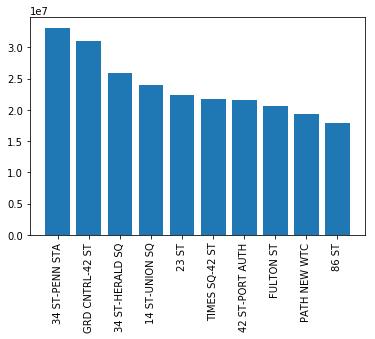

In [113]:
plt.bar(x=station_totals['STATION'][:10], height=station_totals['Total_Ridership_Per_day'][:10])
plt.xticks(rotation=90)

In [ ]:
#next, i am trying to convert the station values in my MTA Wi-Fi Locations data set 
#to match stations names in my MTA turnstiles dataset
#I will upload another notebook that illustrates that part (its not done yet.)